## Stiff polymers
In the previous section, we assumed that the direction of monomers completely randomizes at each junction. 
In reality, the degree to which direction changes is of course constrained and not completely random. 
There are different ways in which such stiffness can be incorporated into models and the overall conformation of the polymer depends on the relation of stiffness to the length of the polymer.

There are two major ways in which such effects are modelled. 
One is by restricting the bond angles of discrete and stiff segments (freely rotating chain), the other is by modeling the polymer as a continuous chain with some stiffness (worm-like chain).

![image.png](figures/stiff_polymer_models.png)

### Freely rotating chain
In this model, bond of two segments is contraint such that the polymer can rotate freely around the azimuth, but has a constrained polar angle $\theta$, either on average or to a fixed value:
$$
\langle \vec{e}_i\vec{e}_{i+1} \rangle = \cos \theta
$$
This has the consequence that the direction of the polymer changes slowly if $\theta$ is small, which we now explore via simulations:


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# return a vector on the sphere with angles theta (polar) and phi (azimuth)
# see https://en.wikipedia.org/wiki/Spherical_coordinate_system
def unit_vector(phi, theta):
    x = np.sin( theta) * np.cos( phi )
    y = np.sin( theta) * np.sin( phi )
    z = np.cos( theta )
    return (x,y,z)    

# return a matrix that rotates a vector 0,0,1 to vec
def rotation_matrix(vec):
    length_xy = np.sqrt(np.sum(vec[:2]**2))
    length = np.sqrt(np.sum(vec**2))
    phi = np.arccos(vec[0]/length_xy)*np.sign(vec[1])
    theta = np.arccos(vec[2]/length)
    xy_rotation = np.array([[np.cos(phi), -np.sin(phi),0],
                     [np.sin(phi), np.cos(phi),0],
                     [0, 0, 1]])
    xz_rotation = np.array([[np.cos(theta), 0 , np.sin(theta)],
                     [0, 1, 0],
                     [-np.sin(theta), 0, np.cos(theta)]])
    # first rotate the vector by theta in the xz plane, followed by phi in the xy plane
    return xy_rotation.dot(xz_rotation)

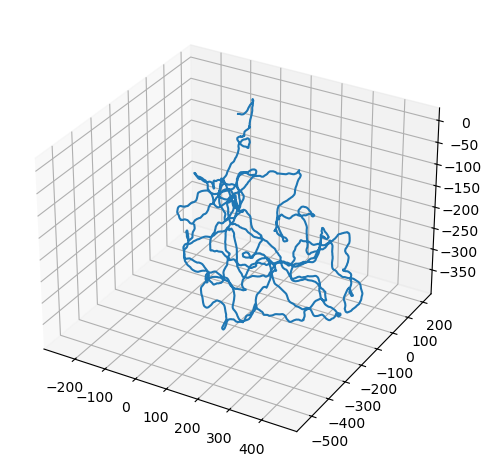

In [5]:
# pick a random new direction given the last direction vec and the angle constraint theta
def new_direction(vec, theta):
    phi = np.random.uniform(0,2*np.pi)
    e = unit_vector(phi, theta)
    return rotation_matrix(vec).dot(e)

# make a freely rotating chain of length N with angle constraint theta and segment length d
def freely_rotating_chain(N, d, theta):
    # initial position
    positions = [ np.array([0,0,0]) ]
    directions = [ np.array([1,0,0]) ]
    for n in range(N):
        # increment position 
        directions.append(new_direction(directions[-1], theta))
        positions.append(positions[-1] + d*directions[-1])

    return np.array(positions)


d = 1
N = 10000
theta = 10/180*np.pi
positions = freely_rotating_chain(N,d=1, theta=theta)

# plot the trajectory
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(positions[:,0], positions[:,1], positions[:,2])
plt.tight_layout()

On short length scales, these polymers look stiff, at least for small $\theta$. On long length scales, this is again just a random coil. 

In fact, one can calculate that the end-to-end distance of such a freely rotating chain
$$
\langle \vec{R}^2 \rangle \approx  d^2 N \frac{1+\cos\theta}{1-\cos \theta}
$$

Text(0, 0.5, 'squared end-to-end distance')

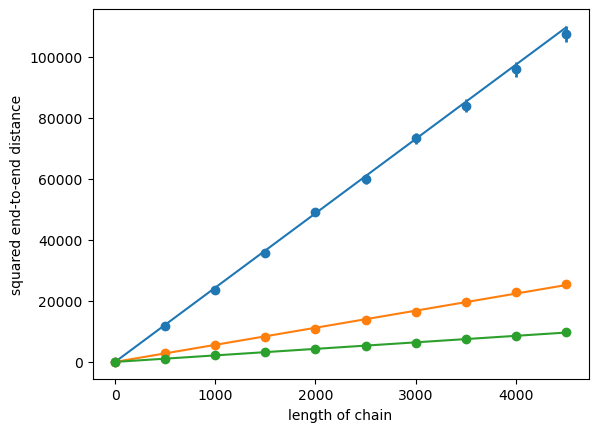

In [6]:
n_max=1000
N = 5000
n_vals = range(0,N,N//10)

for ti, theta in enumerate([0.4, 0.8, 1.2]):
    Rsq = []
    for n in range(n_max):
        polymer = freely_rotating_chain(N, d=1, theta=theta)
        Rsq.append([np.sum(polymer[i]**2) for i in n_vals])

    Rsq = np.array(Rsq)
    plt.errorbar(n_vals, Rsq.mean(axis=0), np.std(Rsq, axis=0)/np.sqrt(n_max-1), marker='o', lw=0, elinewidth=2, c=f'C{ti}')
    plt.plot(n_vals, np.array(n_vals)*(1+np.cos(theta))/(1-np.cos(theta)), c=f'C{ti}')

plt.xlabel('length of chain')
plt.ylabel('squared end-to-end distance')


### Kuhn length and effective models
The end-to-end distance of the freely rotating chain behaves similarly to the freely jointed chain, but instead of 
$$
\langle \vec{R}^2 \rangle \approx  d^2 N
$$
we find
$$
\langle \vec{R}^2 \rangle \approx  d^2 N \frac{1+\cos\theta}{1-\cos \theta}
$$

This behavior is confirmed by our simulation above:

![image.png](figures/end-to-end_distance.png)

This is an important observation: 
**On large length scales, polymers "forget" their microscopic complexity and simply behave like random coils.**
Properties of many polymers can be understood by mapping them onto the simple freely jointed chain be defining an effective segment length. This length is known as the [Kuhn length](https://en.wikipedia.org/wiki/Kuhn_length) $l_k$. 

The argument goes as follows:
 - A polymer of length $L$ is modeled by a freely jointed chain with $N_k$ segments each with length $l_k$. Hence we have $L=N_k l_k$
 - The average squared end-to-end radius is $\langle \vec{R}^2 \rangle$ is supposed to be equal to that of the ideal chain. Hence $\langle \vec{R}^2 \rangle = N_k l_k^2$

Using these two relations, we find for the freely jointed chain
$$
l_k = \frac{d}{\cos (\theta/2)} \frac{1+\cos\theta}{1-\cos \theta}
$$
[Hans Kuhn](https://de.wikipedia.org/wiki/Hans_Kuhn_(Physikochemiker)) worked at the University of Basel for several years. 

Using this insight, we can for example calculate the effective segment length of chromatin from the data by Engh et al (see previous video).
The measurement tells us how the end-to-end distance chances with the contour length of the polymer. Together with the relation $\langle \vec{R}^2 \rangle \approx  l_k^2 N_k$, we can calculate $l_k$ of chromatin.

### Worm-like chain model

Instead of modeling a polymer as discrete stiff segments, the worm-like chain model assumes a continuous filament (much like a spaghetti) that resists bending due to an intrinsic stiffness. 
Models of this type are for example appropriate to model double stranded DNA that is very stiff on the scale of individual base pairs. 

Now that we don't have free joints between segments, we need to get an idea over what length this polymer is effectively stiff and over what length it is floppy in a cell under thermal activation.
Consider a WLC (worm-like chain) with stiffness $\kappa$. Bending an arc-segment of length $L$ into a circle with radius $R$ requires an energy of 
$$
\frac{\kappa L}{2R^2}
$$
![image.png](figures/WLC.png)

By thermal activation, the polymer will chance direction if the bending energy of a segment of length $l$ into a circle of radius $\sim l$ equals the thermal energy:
$$
\frac{\kappa l}{2l^2} = \frac{\kappa}{2 l } \sim kT \quad \Rightarrow \quad l\sim \frac{\kappa}{kT}
$$
To define this length scale more precisely, it is customary to consider the correlation of tangent vectors $\vec{e}(s)$ and $\vec{e}(t)$ at two locations $s$ and $t$ and define the persistence length $l_p$ as the length scale on which the direction correlation decays:

$$
\langle \vec{e}(s)\vec{e}(t)\rangle = \exp(-|t-s|/l_p)
$$

The Kuhn length of the WLC model happens to be twice the persistence length, which is given by $l_p = \kappa/kT$.

### Persistence length of different biopolymers

  * dsDNA: 50nm
  * actin filaments: $17\mu m$
  * microtubule: 1.4 mm
  
  ![image.png](figures/microtubule_actin_structure.png)

#### Dig deeper
 * What happens in the freely-rotating chain model for $\theta = 0$, $\pi/2$ and $\pi$?
 * Recapitulate the calculation of the end-to-end distance in the script!
 